Les graphiques ont été volontairement nettoyés en raison de bugs d'affichage liés aux animations. 

Il est donc nécessaire de redémarrer le notebook pour les visualiser tous.

Ziane Camil

Nakache Eithan



# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait seul ou en binôme. Aucun groupe de plus de 2 personnes. 

Vous allez rendre le TP depuis un lien GitHub avec ce notebook mais une version du rapport exportée en PDF & HTML. 

In [ ]:
# ! pip install matplotlib tqdm numpy ipympl opencv-python
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter labextension install jupyter-matplotlib

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import typing as t
import math
import torch
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output

torch.random.manual_seed(0)

K = 5 # num arms

# Présentation du problème

In [2]:
class ArmBernoulli:
    def __init__(self, p: float):
        """
        Vaccine treatment following a Bernoulli law (mean is p and variance is p(1-p)
        Args:
             p (float): mean parameter
             
        >>> torch.random.manual_seed(random_state)        
        >>> arm = ArmBernoulli(0.5)
        >>> arm.sample(5)
        tensor([ True, False,  True,  True,  True])
        """
        self.immunity_rate = p

    def sample(self, n: int = 1):
        return torch.rand(n) < self.immunity_rate
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.immunity_rate}' 

def generate_arms(num_arms: int):
    means = torch.rand(K)
    MAB = [ArmBernoulli(m) for m in means]
    assert MAB[0].immunity_rate == means[0]
    assert (MAB[0].sample(10) <= 1).all() and (MAB[0].sample(10) >= 0).all() 
    return MAB

MAB = generate_arms(K)

Ce TP reprend l'exemple du médecin présenté en cours.


**Q1. Créez une fonction pour trouver $\mu^*$ à partir d'un `MAB`. Comment est définie la récompense $R_k$ ? Que représente concrètement le regret dans le contexte de ce TP ?**

In [3]:
torch.random.manual_seed(0)
mab = generate_arms(5)
def get_mu_star(mab: list[ArmBernoulli] ):
    mu_star = max([m.immunity_rate for m in mab])
    return mu_star
get_mu_star(mab)

tensor(0.7682)

$\mu^*$ vaut à 0.7682 et correspond au meilleur vaccin

La récompense $R_k$ correspond à l'immunity rate

Le regret correspond à la difference entre l'immunity rate du meilleur vaccin et le vaccin k

**Note importante :** pour la suite, les résultats seront généralement réalisés avec 100 initialisations différentes du MAB (tous les MAB ont 5 vaccins mais des taux d'immunistation différent) pour réduire le bruit de simulation. Concrètement, on exécutera au moins 100x `generate_arms`.

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. **Exploration :** Le médecin calcule le taux d'immunisation empirique sur les N premiers patients en administrant le même nombre de fois chaque vaccin :

$$\hat{\mu_i}[0\rightarrow N] = \frac{1}{T_i} \sum_{k=0}^{N-1} \chi_{v_k,i}R_k,$$

avec $T_i = \sum_{k=0}^{N-1} \chi_{v_k,i}$.


2. **Exploitation :** Le vaccin $v_i = \arg\max_j \hat{\mu_j}[0\rightarrow N]$ est utilisé pour les M patients suivants.

**Q2. Implémentez cette solution avec N = 50 et M = 500 et testez-la avec 100 MAB. On souhaite savoir si vous trouvez les bons vaccins optimals. Quelle est l'espérance empirique de cette variable ? Et son écart-type ? Calculez de même l'espérance et l'écart-type du regret sur vos 100 simulations.**

Pour rappel, le regret est défini par :

$$r_n = n\mu^* - \sum_{k=0}^{n-1} R_k$$

**Attention :** $n$ est le nombre total de patients, donc ici $N + M$.

In [58]:
torch.random.manual_seed(0)
nb_mab = 100
nb_vaccin = 5
mabs = [generate_arms(nb_vaccin) for _ in range(nb_mab)]
N = 50
M = 500

In [5]:
def exploration(N, mab, empirical_rates, trials, indicator, rewards):
    nb_vaccin = len(mab)
    actual_rewards = torch.zeros(N)
    vaccine_to_choose = torch.randint(0, nb_vaccin, (N,))
    for i in range(N):
        v = vaccine_to_choose[i]
        actual_rewards[i] = mab[v].sample()
    rewards = torch.cat([rewards, actual_rewards])
    indicator = torch.cat([indicator, torch.eye(
        nb_vaccin)[vaccine_to_choose].T], dim=1)
    trials = trials + torch.bincount(vaccine_to_choose, minlength=nb_vaccin)
    empirical_rates = (indicator @ rewards)/trials
    empirical_rates = empirical_rates.nan_to_num()
    return empirical_rates, trials, indicator, rewards


def exploitation(M, mab, empirical_rate, trials, indicator, rewards):
    nb_vaccin = len(mab)
    best_vaccine_index = torch.argmax(empirical_rate)
    vaccine_to_choose = torch.ones(M, dtype=torch.int64) * best_vaccine_index
    exploit_rewards = mab[best_vaccine_index].sample(M)
    rewards = torch.cat([rewards, exploit_rewards])
    indicator = torch.cat([indicator, torch.eye(nb_vaccin)[vaccine_to_choose].T], dim=1)
    trials = trials + torch.bincount(vaccine_to_choose, minlength=nb_vaccin)
    empirical_rate = (indicator @ rewards)/trials
    return empirical_rate, trials, indicator, rewards


def compute_regret(mab, rewards):
    nb_trials = len(rewards)
    mu_star = get_mu_star(mab)
    return nb_trials * mu_star - torch.sum(rewards)


def run_simulation(N, M, mab, exploitation):
    # exploration
    trials = torch.zeros(len(mab))
    indicator = torch.zeros((len(mab), 0))
    rewards = torch.zeros(0)
    empirical_rates_exploration, trials, indicator, rewards = exploration(
                                                                          N=N,
                                                                          mab=mab,
                                                                          empirical_rates=None,
                                                                          trials=trials,
                                                                          indicator=indicator,
                                                                          rewards=rewards)
    # exploitation
    exploitaion_res = exploitation(
        M, mab, empirical_rates_exploration, trials, indicator, rewards)
    empirical_rates, trials, indicator, rewards = (exploitaion_res[i] for i in range(4))
    
    # regret
    regret = compute_regret(mab, rewards)

    # check if the best vaccine was found
    best_exploration_vaccine_index = torch.argmax(
        empirical_rates_exploration).item()
    best_exploitation_vaccine_index = torch.argmax(empirical_rates).item()
    true_best_vaccine_index = torch.argmax(
        torch.tensor([arm.immunity_rate for arm in mab])).item()
    found_best_exploration = best_exploration_vaccine_index == true_best_vaccine_index
    found_best_exploitation = best_exploitation_vaccine_index == true_best_vaccine_index

    return found_best_exploration, found_best_exploitation, regret.item()

In [6]:
def analyze_results(results):
    found_best_vaccines = torch.tensor([res[0:2] for res in results], dtype=torch.float)
    regrets = torch.tensor([res[2] for res in results], dtype=torch.float)
    # print(found_best_vaccines)
    mean_found_best = found_best_vaccines.mean(dim=0)
    std_found_best = found_best_vaccines.std(dim=0)

    mean_regret = regrets.mean().item()
    std_regret = regrets.std().item()

    print(f"Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: {mean_found_best[0]:.2f}")
    print(f"Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: {mean_found_best[1]:.2f}")
    print(f"Écart-type trouver le meilleur vaccin pendant la phase d'exploration: {std_found_best[0]:.2f}")
    print(f"Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: {std_found_best[1]:.2f}")
    print(f"Espérance du regret: {mean_regret:.2f}")
    print(f"Écart-type du regret: {std_regret:.2f}")

In [7]:
torch.random.manual_seed(0)
results = [run_simulation(50, M, mab, exploitation) for mab in mabs]
analyze_results(results)

Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: 0.70
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: 0.77
Écart-type trouver le meilleur vaccin pendant la phase d'exploration: 0.46
Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: 0.42
Espérance du regret: 29.36
Écart-type du regret: 30.80


**Q3. On propose d'améliorer l'algorithme précédant en mettant à jour les taux d'immunisation empiriques $\bar{R}_i$ pendant la d'exploitation. Notez vous une amélioration du regret ? Proposez un exemple dans lequel cette mise à jour ne changera rien.** 

In [8]:
def greedy_exploitation(M, mab, empirical_rate, trials, indicator, rewards):
    nb_vaccin = len(mab)
    for _ in range(M):
        best_vaccine_index = torch.argmax(empirical_rate)
        vaccine_to_choose = torch.ones(1, dtype=torch.int64) * best_vaccine_index
        exploit_rewards = mab[best_vaccine_index].sample(1)
        rewards = torch.cat([rewards, exploit_rewards])
        indicator = torch.cat([indicator, torch.eye(
            nb_vaccin)[vaccine_to_choose].T], dim=1)
        trials = trials + torch.bincount(vaccine_to_choose, minlength=nb_vaccin)
        empirical_rate = (indicator @ rewards)/trials
    return empirical_rate, trials, indicator, rewards

In [9]:
torch.manual_seed(0)
results = [run_simulation(N, M, mab, exploitation=greedy_exploitation) for mab in mabs]
analyze_results(results)

Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: 0.70
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: 0.85
Écart-type trouver le meilleur vaccin pendant la phase d'exploration: 0.46
Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: 0.36
Espérance du regret: 19.97
Écart-type du regret: 12.82


Il y a une amélioration du regret d'environ -32%.


In [10]:
torch.random.manual_seed(0)
mab_skewed = [[ArmBernoulli(0.05) for _ in mab[:-1]] + [ArmBernoulli(0.9)] for mab in mabs]

results = [run_simulation(N, M, mab, exploitation=exploitation) for mab in mab_skewed]
print("Result for skewed MAB and  normal exploitation")
analyze_results(results)

print()

print("Result for skewed MAB and  greedy exploitation")
results = [run_simulation(N, M, mab, exploitation=greedy_exploitation) for mab in mab_skewed]

analyze_results(results)

Result for skewed MAB and  normal exploitation
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: 1.00
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: 1.00
Écart-type trouver le meilleur vaccin pendant la phase d'exploration: 0.00
Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: 0.00
Espérance du regret: 34.27
Écart-type du regret: 7.01

Result for skewed MAB and  greedy exploitation
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: 1.00
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: 1.00
Écart-type trouver le meilleur vaccin pendant la phase d'exploration: 0.00
Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: 0.00
Espérance du regret: 33.70
Écart-type du regret: 7.40


On remarque qu'avec un ensemble de MAB composé de 5 vaccins, dont 4 ayant des probabilités très faibles (<0,1) et un outsider avec une probabilité beaucoup plus élevée (>0,9), cette amélioration ne change rien. Le meilleur vaccin a déjà été identifié dès la première phase, en raison de la grande différence dans les taux d'immunité.

On peut remarquer ici une amélioration du regret de seulement -1.6%. Soit une réduction d'amélioration de -95% par rapport à l'ancien set de MAB

**Q4. Créez une figure contenant deux sous-figures : à gauche, le taux d'immunisation empirique $\bar{R}_i$ pour les 5 vaccins ; à droite, le regret $r_n$. La figure sera animée avec les patients : chaque frame $k$ de l'animation représente le vaccin que l'on donne au $k$-ième patient.**

In [11]:
torch.random.manual_seed(0)

def step_by_step_simulation(mab, N, M, exploitation):
    empirical_rates_history = []
    trials_history = []
    regrets = []
    trials = torch.zeros(len(mab))
    indicator = torch.zeros((len(mab), 0))
    rewards = torch.zeros(0)
    # exploration
    for _ in range(0, N):
        empirical_rates, trials, indicator, rewards = exploration(1, mab, empirical_rates=None, trials=trials, indicator=indicator, rewards=rewards)
        empirical_rates_history.append(empirical_rates)
        trials_history.append(trials)
        regret = compute_regret(mab, rewards)
        regrets.append(regret)
    # exploitation
    for _ in range(M):
        empirical_rates, trials, indicator, rewards = exploitation(
            1, mab, empirical_rates, trials, indicator, rewards)
        empirical_rates_history.append(empirical_rates)
        trials_history.append(trials)
        regret = compute_regret(mab, rewards)
        regrets.append(regret)
        # print(rewards)
        # print(len(rewards))
    
    return empirical_rates_history, trials_history, regrets, rewards

In [ ]:
%matplotlib widget
torch.random.manual_seed(0)
def animate_patients(mab, N, M):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), num="Simulation Patient par Patient")
    # change name of the figure from figure 1 to figure 2
    ax[0].set_title('Taux d\'immunisation empirique')
    ax[0].set_xlabel('Vaccins')
    ax[0].set_ylabel('Taux d\'immunisation')
    ax[0].set_ylim(0, 1)
    ax[0].grid(True)

    ax[1].set_title('Regret')
    ax[1].set_xlabel('Patients')
    ax[1].set_ylabel('Regret')
    ax[1].grid(True) 
    
    torch.random.manual_seed(0)
    empirical_rates_history, _, regrets, _ = step_by_step_simulation(mab, N, M, exploitation)
    patients = np.arange(0, len(empirical_rates_history[0]))  
    def update(frame):
        ax[0].cla()
        ax[1].cla()        
        # Redraw titles and labels for each frame after clearing
        ax[0].set_title(f"Taux d\'immunisation empirique - {'Exploitation' if frame > N else 'Exploration'}")
        ax[0].set_xlabel('Vaccins')
        ax[0].set_ylabel('Taux d\'immunisation')
        ax[0].set_ylim(0, 1)
        ax[0].grid(True)

        ax[0].set_title(f"Regret - {'Exploitation' if frame > N else 'Exploration'}")
        ax[1].set_xlabel('Patients')
        ax[1].set_ylabel('Regret')
        ax[1].grid(True)
        
        # print(empirical_rates)
        ax[0].set_xticks(np.arange(len(empirical_rates_history[0]))) 
        ax[0].bar(patients,empirical_rates_history[frame], label='Taux d\'immunisation empirique')
        ax[1].plot(regrets[:frame], label='Regret')
    
    anim = FuncAnimation(fig, update, frames=np.arange(0, N+M), repeat=False)
    return anim

ani = animate_patients(mab, N, M)
plt.show()

**Q5. On étudie maintenant l'influence de la taille du training set $N$. On considère que N+M est une constante, puis on fait varier N entre K et M. Calculez le regret pour ces différentes tailles du training set  différents MAB et representez le regret moyen, le regret min et max (vous devriez trouver une courbe en U ou en V pour le regret moyen). Quelle est la taille optimale du training set ?**

In [42]:
torch.random.manual_seed(0)
nb_mab = 20
nb_vaccin = 5
q5_mabs = [generate_arms(nb_vaccin) for _ in range(nb_mab)]
N = 50
M = 500

In [ ]:
torch.random.manual_seed(0)
results = [[run_simulation(k, M+N-k, mab, exploitation) for  mab in q5_mabs ]for k in range(10, 500, 10)]
regrets = [[res[2] for res in result] for result in results]
regrets_mean = [ np.array([regret for regret in reg]).mean() for reg in regrets]
regrets_max = [ np.array([regret for regret in reg]).max() for reg in regrets]
regrets_min = [ np.array([regret for regret in reg]).min() for reg in regrets]

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
x = np.arange(10,500,10)
ax[0][0].set_title('Regret moyen')
ax[0][0].set_ylabel('Regret')
ax[0][0].set_xlabel('Taille de l\'entrainement')
ax[0][0].plot(x, regrets_mean, label='Regret moyen')
ax[0][1].set_ylabel('Regret')
ax[0][1].set_xlabel('Taille de l\'entrainement')
ax[0][1].set_title('Regret Max')
ax[0][1].plot(x, regrets_max, label='Regret max')
ax[1][0].set_ylabel('Regret')
ax[1][0].set_xlabel('Taille de l\'entrainement')
ax[1][0].set_title('Regret Min')
ax[1][0].plot(x,regrets_min, label='Regret min')
optimal_training_size = np.arange(10,500,10)[np.array(regrets_mean).argmin()]
print(f"Taille optimale de l'entrainement: {optimal_training_size}")

La taille optimale de l'entrainement est de 50 patients

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Lai et Robbins [Lai et Robbins, 1985] considère une classe d'algorithmes $\pi$ pour résoudre ce type de problèmes.

Ils ont trouvé une borne inférieure sur les récompenses cumulées en valeur asymptotique :

$$\lim_{n\rightarrow \infty} \inf_{\pi} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)}  :=C(\mu)$$
 
 avec $\text{KL}(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ (distance de Kullback-Leibler) et  $\sum_{k=0}^{n-1} R_k$ la récompense obtenue sur $n$ patients.
 
 
**Q6. Justifiez pourquoi on peut en déduire que le regret d'un algorithme raisonnable sera au pire logarithmique.**

En faisant passé le log(n) de l'autre coté on remarque que le regret doit croitre au moins aussi rapidement qu'une constante fois log(n)

**Q7. Tracez le regret issu de la borne de Lai & Robbins et comparez le au regret obtenu avec l'algorithme glouton.**

In [28]:
def lai_robbins(mab, N, M):
    def KL(x,y):
        return x * torch.log(x/y) + (1-x) * torch.log((1-x)/(1-y))
    lai_robbins_regrets = []
    n = N+M
    for i in range(n):
        mu_star = get_mu_star(mab)
        mus = torch.tensor([arm.immunity_rate for arm in mab if arm.immunity_rate != mu_star])
        coef = torch.sum((mu_star - mus)/KL(mus, mu_star))
        lai_robbins_regret =  coef * torch.log(torch.tensor(i))
        lai_robbins_regrets.append(lai_robbins_regret.item())
    return lai_robbins_regrets

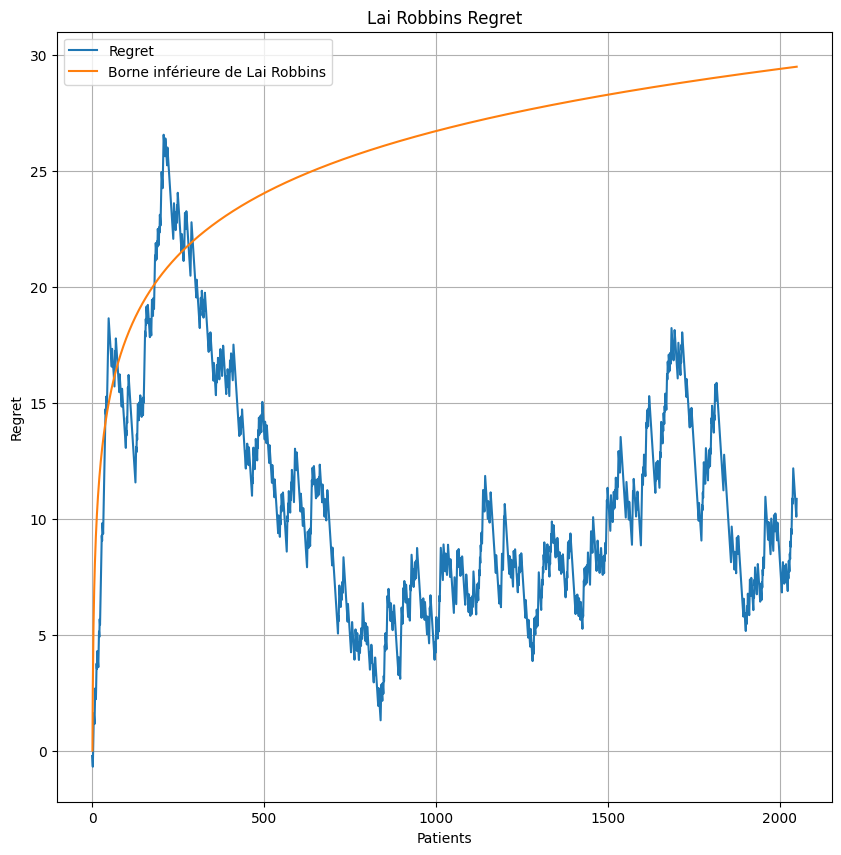

In [35]:
%matplotlib inline
torch.random.manual_seed(3)
M_inf = 2000
empirical_rates_history, trials_history, regrets, rewards = step_by_step_simulation(mab, N, M_inf, exploitation)
lai_robbins_regrets = lai_robbins(mab, N, M_inf)
fig, ax = plt.subplots(1, 1, figsize=(10, 10), num="Regret")
ax.cla()
ax.set_title('Lai Robbins Regret')
ax.set_xlabel('Patients')
ax.set_ylabel('Regret')
ax.grid(True)
ax.plot(torch.tensor(regrets), label='Regret')
ax.plot(lai_robbins_regrets, label='Borne inférieure de Lai Robbins')
ax.legend()
plt.show()

On observe que, bien que le regret diminue, l'algorithme descend en dessous de la borne de Lai et Robbins. Ainsi, l'algorithme glouton atteint un minimum local (qui est global dans ce cas précis en raison de la simplicité du problème). Cependant, cet algorithme ne généralisera pas à des problèmes plus complexes.

## I.c. Upper Confidence Bounds

Cet algorithme améliore la version précédente en ajoutant un biais lié à la fréquentation de chaque vaccin :

$$\hat{R}_i = \bar{R}_i + \sqrt{\frac{C \log{n}}{T_i}},$$

avec $C = 2$.

**Q8. Implémentez la modification de cette algorithme. Conservez les deux phases exploration/exploitation décrites ci-dessus. En prenant les valeurs de $N$ et $M$ trouvées à la question Q5, quel regret obtenez-vous ? Faites l'expérience avec au moins 10 MAB différents (tous ayant 5 vaccins) afin de calculer la moyenne et l'écart-type du regret.**

In [15]:
def ucb_exploitation(M, mab, empirical_rate, trials, indicator, rewards, C=2):
    nb_vaccin = len(mab)
    for _ in range(M):
        ucb_empirical_rate = empirical_rate + torch.sqrt((C * np.log(len(rewards))) / trials)
        best_vaccine_index = torch.argmax(ucb_empirical_rate)
        vaccine_to_choose = torch.ones(1, dtype=torch.int64) * best_vaccine_index
        exploit_rewards = mab[best_vaccine_index].sample(1)
        rewards = torch.cat([rewards, exploit_rewards])
        indicator = torch.cat([indicator, torch.eye(
            nb_vaccin)[vaccine_to_choose].T], dim=1)
        trials = trials + torch.bincount(vaccine_to_choose, minlength=nb_vaccin)
        empirical_rate = (indicator @ rewards)/trials
    ucb_empirical_rate = empirical_rate + torch.sqrt((C * np.log(len(rewards))) / trials)
    return empirical_rate, trials, indicator, rewards, ucb_empirical_rate

In [16]:
torch.random.manual_seed(0)
results = [run_simulation(N, M, mab, exploitation=ucb_exploitation) for mab in mabs]
analyze_results(results)

Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: 0.70
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: 0.92
Écart-type trouver le meilleur vaccin pendant la phase d'exploration: 0.46
Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: 0.27
Espérance du regret: 47.93
Écart-type du regret: 11.34


On constate une augmentation de 42,22 % du regret par rapport à l'algorithme glouton (33,7 -> 47,93), ce qui était prévisible, car l'algorithme se situait initialement en dessous de la borne de Lai et Robbins.

L'espérance de trouver le meilleur vaccin durant la phase d'exploitation a progressé de 8,24 % (0,85 -> 0,92), ce qui était également attendu. En effet, cette phase permet de tester davantage les vaccins moins souvent sélectionnés, qui ont pu être défavorisés par un manque de chance au départ.

L'écart-type du regret est également plus faible que celui de l'algorithme glouton, avec une réduction de 5,5 % (12,0 -> 11,34). Un écart-type plus bas indique un regret plus stable.

**Q9. Reprenez la questions Q4 avec cette algorithme. Dans la figure de gauche, vous representerez $\bar{R}_i$ et $\hat{R}_i$.**

In [23]:
torch.random.manual_seed(0)

def step_by_step_simulation_exploration(mab,N):
    empirical_rates_history = []
    trials_history = []
    regrets = []
    trials = torch.zeros(len(mab))
    indicator = torch.zeros((len(mab), 0))
    rewards = torch.zeros(0)
    # exploration
    for _ in range(0, N):
        empirical_rates, trials, indicator, rewards = exploration(1, mab, empirical_rates=None, trials=trials, indicator=indicator, rewards=rewards)
        empirical_rates_history.append(empirical_rates)
        trials_history.append(trials)
        regret = compute_regret(mab, rewards)
        regrets.append(regret)
    return empirical_rates_history, trials_history, regrets, empirical_rates, trials, indicator, rewards
    
def step_by_step_simulation_exploitation_ucb(mab, M, exploitation, empirical_rates, trials, indicator, rewards, empirical_rates_history, trials_history, regrets):
    empirical_rates_ucb_history = empirical_rates_history.copy()
    for _ in range(M):
        empirical_rates, trials, indicator, rewards, empirical_rates_ucb = exploitation(
            1, mab, empirical_rates, trials, indicator, rewards)
        empirical_rates_history.append(empirical_rates)
        empirical_rates_ucb_history.append(empirical_rates_ucb)
        trials_history.append(trials)
        regret = compute_regret(mab, rewards)
        regrets.append(regret)
    
    return empirical_rates_history, trials_history, regrets, rewards, empirical_rates_ucb_history

In [ ]:
%matplotlib widget
torch.random.manual_seed(0)
def animate_patients_compare(mab, N, M):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10), num="Simulation Patient par Patient Comparaison Glouton UCB")
    # change name of the figure from figure 1 to figure 2
    ax[0][0].set_title('Taux d\'immunisation empirique')
    ax[0][0].set_xlabel('Vaccins')
    ax[0][0].set_ylabel('Taux d\'immunisation')
    ax[0][0].set_ylim(0, 1)
    ax[0][0].grid(True)

    ax[0][1].set_title('Taux d\'immunisation empirique UCB')
    ax[0][1].set_xlabel('Vaccins')
    ax[0][1].set_ylabel('Taux d\'immunisation')
    ax[0][1].set_ylim(0, 1)
    ax[0][1].grid(True)

    ax[1][0].set_title('Regret')
    ax[1][0].set_xlabel('Patients')
    ax[1][0].set_ylabel('Regret')
    ax[1][0].grid(True) 
    
    torch.random.manual_seed(0)
    empirical_rates_history, trials_history, regrets, empirical_rates, trials, indicator, rewards = step_by_step_simulation_exploration(mab, N)
    empirical_rates_history, trials_history, regrets, rewards, empirical_rates_history_ucb= step_by_step_simulation_exploitation_ucb(mab,M, ucb_exploitation, empirical_rates,trials, indicator,rewards,empirical_rates_history, trials_history, regrets)
    patients = np.arange(0, len(empirical_rates_history[0]))  
    def update(frame):
        ax[0][0].cla()
        ax[0][1].cla()
        ax[1][0].cla()        
        # Redraw titles and labels for each frame after clearing
        ax[0][0].set_title(f"Taux d\'immunisation empirique - {['Exploration', 'Exploitation'][frame > N]}")
        ax[0][0].set_xlabel('Vaccins')
        ax[0][0].set_ylabel('Taux d\'immunisation')
        ax[0][0].set_ylim(0, 1)
        ax[0][0].grid(True)

        ax[0][1].set_title(f"Taux d\'immunisation empirique UCB - {['Exploration', 'Exploitation'][frame > N]}")
        ax[0][1].set_xlabel('Vaccins')
        ax[0][1].set_ylabel('Taux d\'immunisation')
        ax[0][1].grid(True)

        ax[1][0].set_title(f'Regret - {["Exploration", "Exploitation"][frame > N]}')
        ax[1][0].set_xlabel('Patients')
        ax[1][0].set_ylabel('Regret')
        ax[1][0].grid(True)
        
        # print(empirical_rates)
        ax[0][0].set_xticks(np.arange(len(empirical_rates_history[0]))) 
        ax[0][0].bar(patients,empirical_rates_history[frame], label='Taux d\'immunisation empirique')
        ax[0][1].set_xticks(np.arange(len(empirical_rates_history[0]))) 
        ax[0][1].bar(patients,empirical_rates_history_ucb[frame], label='Taux d\'immunisation empirique')
        ax[1][0].plot(regrets[:frame], label='Regret')
    
    anim = FuncAnimation(fig, update, frames=np.arange(N, N+M), repeat=False)
    return anim

ani = animate_patients_compare(mab, N, M)
plt.show()

**Q10. Reprenez la question Q5 avec cette algorithme. Concluez sur l'utilité (ou l'inutilité) de la phase d'exploration. Comparez les performances d'UCB avec celles de l'algorithme glouton.**

In [25]:
torch.random.manual_seed(0)
results = [[run_simulation(k, M+N-k, mab, ucb_exploitation) for  mab in q5_mabs ]for k in range(10, 500, 10)]
regrets = [[res[2] for res in result] for result in results]
regrets_mean = [ np.array([regret for regret in reg]).mean() for reg in regrets]
regrets_max = [ np.array([regret for regret in reg]).max() for reg in regrets]
regrets_min = [ np.array([regret for regret in reg]).min() for reg in regrets]

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
x = np.arange(10,500,10)
ax[0][0].set_title('Regret moyen')
ax[0][0].set_ylabel('Regret')
ax[0][0].set_xlabel('Taille de l\'entrainement')
ax[0][0].plot(x, regrets_mean, label='Regret moyen')
ax[0][1].set_ylabel('Regret')
ax[0][1].set_xlabel('Taille de l\'entrainement')
ax[0][1].set_title('Regret Max')
ax[0][1].plot(x, regrets_max, label='Regret max')
ax[1][0].set_ylabel('Regret')
ax[1][0].set_xlabel('Taille de l\'entrainement')
ax[1][0].set_title('Regret Min')
ax[1][0].plot(x,regrets_min, label='Regret min')
optimal_training_size = np.arange(10,500,10)[np.array(regrets_mean).argmin()]
print(f"Taille optimale de l'entrainement: {optimal_training_size}")

La taille optimale de l'entraînement étant de 10 patients, on peut en déduire que la phase d'entraînement est superflue dans ce contexte.

**Q11. Testez différentes valeurs pour $C$ et trouvez sa valeur optimale expérimentalement.**

In [ ]:
torch.random.manual_seed(0)
from functools import partial
results = []
Cs = np.logspace(0.01, 4, 10)
for C in Cs:
    ucb_exploitation_partial = partial(ucb_exploitation, C=C)
    results.append([run_simulation(N, M, mab, ucb_exploitation_partial ) for mab in mabs])
regrets = [[res[2] for res in result] for result in results]
regrets_mean = [ np.array([regret for regret in reg]).mean() for reg in regrets]
regrets_max = [ np.array([regret for regret in reg]).max() for reg in regrets]
regrets_min = [ np.array([regret for regret in reg]).min() for reg in regrets]

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax[0][0].set_title('Regret moyen')
ax[0][0].set_ylabel('Regret')
ax[0][0].set_xlabel('C')
ax[0][0].plot(Cs, regrets_mean, label='Regret moyen')
ax[0][1].set_ylabel('Regret')
ax[0][1].set_xlabel('C')
ax[0][1].set_title('Regret Max')
ax[0][1].plot(Cs, regrets_max, label='Regret max')
ax[1][0].set_ylabel('Regret')
ax[1][0].set_xlabel('C')
ax[1][0].set_title('Regret Min')
ax[1][0].plot(Cs,regrets_min, label='Regret min')
optimal_training_size = Cs[np.array(regrets_mean).argmin()]
print(f"Taille optimale de C: {optimal_training_size}")

Le C optimale expérimentalement est 1.02

# Echantillonnage de Thomson

Cet algorithme propose de modéliser la variable aléatoire de chaque vaccin avec une loi $\beta$ dont les paramètres $a$ et $b$ correspondent au nombre de patients que le vaccin a immunisés (resp. non immunisés).

Pour chaque patient, on tire un valeur aléatoire pour la loi $\beta$ décrivant chaque vaccin, puis on choisit le vaccin avec la plus grande valeur tirée. 

**Q12. Implémentez cet algorithme. Conservez les deux phases exploration/exploitation décrites ci-dessus. En prenant les valeurs de $N$ et $M$ trouvées à la question Q5, quel regret obtenez-vous ? Faites l'expérience avec au moins 10 MAB différents (tous ayant 5 vaccins) afin de calculer la moyenne et l'écart-type du regret.**

In [32]:
def thompson_exploitation(M, mab, empirical_rate, trials, indicator, rewards):
    nb_vaccin = len(mab)
    for _ in range(M):
        vaccine_successes = indicator @ rewards
        vaccine_failures = trials - vaccine_successes
        vaccine_betas = torch.distributions.beta.Beta(vaccine_successes + 1, vaccine_failures + 1)
        betas_samples = vaccine_betas.sample()
        best_vaccine_index = torch.argmax(betas_samples)
        vaccine_to_choose = torch.ones(1, dtype=torch.int64) * best_vaccine_index
        exploit_rewards = mab[best_vaccine_index].sample(1)
        rewards = torch.cat([rewards, exploit_rewards])
        indicator = torch.cat([indicator, torch.eye(
            nb_vaccin)[vaccine_to_choose].T], dim=1)
        trials = trials + torch.bincount(vaccine_to_choose, minlength=nb_vaccin)
        empirical_rate = (indicator @ rewards)/trials
    return empirical_rate, trials, indicator, rewards, torch.vstack([vaccine_successes, vaccine_failures]).T

In [59]:
torch.random.manual_seed(0)
results = [run_simulation(N, M, mab, exploitation=thompson_exploitation) for mab in mabs]
analyze_results(results)

Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: 0.74
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: 0.90
Écart-type trouver le meilleur vaccin pendant la phase d'exploration: 0.44
Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: 0.30
Espérance du regret: 22.22
Écart-type du regret: 8.21


En raison de l'échantillonnage de la fonction bêta, les phases d'exploration diffèrent des tests précédents. Cependant, les résultats demeurent comparables.

On observe que l'espérance et l'écart-type du regret sont plus faibles que dans tous les autres tests. 

L'écart-type suggère un regret plus stable, mais une espérance de regret très basse n'est pas nécessairement un bon signe, car cela pourrait indiquer que cet algorithme ne se généralise pas bien.

Enfin, l'espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation reste légèrement inférieure à celle de l'algorithme UCB.

**Q13. Reprenez la question Q4, mais cette fois-ci, vous representerez le taux d'immunisation empirique avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot) qui représente la loi beta associée à chaque vaccin.**

In [36]:
torch.random.manual_seed(0)

def step_by_step_simulation_thompson(mab, N, M):
    empirical_rates_history = []
    trials_history = []
    regrets = []
    trials = torch.zeros(len(mab))
    indicator = torch.zeros((len(mab), 0))
    rewards = torch.zeros(0)
    betas_history = []
    # exploration
    for _ in range(0, N):
        empirical_rates, trials, indicator, rewards = exploration(1, mab, empirical_rates=None, trials=trials, indicator=indicator, rewards=rewards)
        empirical_rates_history.append(empirical_rates)
        trials_history.append(trials)
        regret = compute_regret(mab, rewards)
        regrets.append(regret)
    # exploitation
    for _ in range(M):
        empirical_rates, trials, indicator, rewards, betas = thompson_exploitation(
            1, mab, empirical_rates, trials, indicator, rewards)
        empirical_rates_history.append(empirical_rates)
        trials_history.append(trials)
        regret = compute_regret(mab, rewards)
        regrets.append(regret)
        betas_history.append(betas)
        # print(rewards)
        # print(len(rewards))
    
    return empirical_rates_history, trials_history, regrets, rewards, betas_history

In [ ]:
%matplotlib widget
torch.random.manual_seed(0)
def animate_patients(mab, N, M):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), num="Simulation Patient par Patient")
    # change name of the figure from figure 1 to figure 2
    ax[0].set_title('Taux d\'immunisation empirique')
    ax[0].set_xlabel('Vaccins')
    ax[0].set_ylabel('Taux d\'immunisation')
    ax[0].set_ylim(0, 1)
    ax[0].grid(True)

    ax[1].set_title('Regret')
    ax[1].set_xlabel('Patients')
    ax[1].set_ylabel('Regret')
    ax[1].grid(True) 
    
    torch.random.manual_seed(0)
    empirical_rates_history, trials_history, regrets, rewards, betas_history = step_by_step_simulation_thompson(mab, N, M)
    patients = np.arange(0, len(empirical_rates_history[0]))  
    datas = [[torch.distributions.Beta(beta[0]+1, beta[1]+1).sample((1000,)) for beta in betas] for betas in betas_history]
    def update(frame):
        ax[0].cla()
        ax[1].cla()        
        # Redraw titles and labels for each frame after clearing
        ax[0].set_title(f"Taux d\'immunisation empirique - {['Exploration', 'Exploitation'][frame > N]}")
        ax[0].set_xlabel('Vaccins')
        ax[0].set_ylabel('Taux d\'immunisation')
        ax[0].set_ylim(0, 1)
        ax[0].grid(True)

        ax[1].set_title(f'Regret - {["Exploration", "Exploitation"][frame > N]}')
        ax[1].set_xlabel('Patients')
        ax[1].set_ylabel('Regret')
        ax[1].grid(True)
        
        # print(empirical_rates)
        ax[0].set_xticks(np.arange(len(empirical_rates_history[0]))) 
        # ax[0].bar(patients,empirical_rates_history[N+frame], label='Taux d\'immunisation empirique')
        ax[0].violinplot([data.numpy() for data in datas[frame]], showmeans=False, showmedians=True)
        ax[1].plot(regrets[:N+frame], label='Regret')
    
    anim = FuncAnimation(fig, update, frames=np.arange(0, M), repeat=False)
    return anim

ani = animate_patients(mab, N, M)
plt.show()

On constate que le deuxième vaccin se stabilise autour d'une valeur de 0,76, avec une variance qui diminue progressivement.

**Q14. Représentez son regret pour différentes tailles du training set (comme dans la Q5). Comparez le regret avec les autres algorithmes.**

In [45]:
torch.random.manual_seed(0)
results = [[run_simulation(k, M+N-k, mab, thompson_exploitation) for  mab in q5_mabs ]for k in range(10, 500, 20)]
regrets = [[res[2] for res in result] for result in results]
regrets_mean = [ np.array([regret for regret in reg]).mean() for reg in regrets]
regrets_max = [ np.array([regret for regret in reg]).max() for reg in regrets]
regrets_min = [ np.array([regret for regret in reg]).min() for reg in regrets]

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
x = np.arange(10,500,20)
ax[0][0].set_title('Regret moyen')
ax[0][0].set_ylabel('Regret')
ax[0][0].set_xlabel('Taille de l\'entrainement')
ax[0][0].plot(x, regrets_mean, label='Regret moyen')
ax[0][1].set_ylabel('Regret')
ax[0][1].set_xlabel('Taille de l\'entrainement')
ax[0][1].set_title('Regret Max')
ax[0][1].plot(x, regrets_max, label='Regret max')
ax[1][0].set_ylabel('Regret')
ax[1][0].set_xlabel('Taille de l\'entrainement')
ax[1][0].set_title('Regret Min')
ax[1][0].plot(x,regrets_min, label='Regret min')
optimal_training_size = np.arange(10,500,20)[np.array(regrets_mean).argmin()]
print(f"Taille optimale de l'entrainement: {optimal_training_size}")

Le regret augmente avec la taille de l'entraînement, rendant ce dernier inutile. On observe les mêmes conclusions que pour le regret en phase d'exploitation de l'algorithme UCB. Ainsi, ces deux algorithmes sont indépendants de la phase d'entraînement, contrairement à l'algorithme glouton.

# Conclusion

**Q15. Calculez le regret des algorithmes glouton, UCB & Thomson lorsqu'il y a un grand nombre de vaccins disponibles (K=100) (on prendra N=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**

In [49]:
torch.random.manual_seed(0)
nb_mab = 100
nb_vaccin = 100
mabs = [generate_arms(nb_vaccin) for _ in range(nb_mab)]
N = 100
M = 500

In [51]:
torch.random.manual_seed(0)
glouton_results = [run_simulation(N, M, mab, exploitation) for mab in mabs]
print("Algorithme Glouton")
analyze_results(glouton_results)

Algorithme Glouton
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: 0.82
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: 0.84
Écart-type trouver le meilleur vaccin pendant la phase d'exploration: 0.39
Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: 0.37
Espérance du regret: 42.15
Écart-type du regret: 28.51


In [54]:
torch.random.manual_seed(0)
ucb_results = [run_simulation(N, M, mab, ucb_exploitation) for mab in mabs]
print("Algorithme UCB")
analyze_results(ucb_results)

Algorithme UCB
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: 0.82
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: 0.91
Écart-type trouver le meilleur vaccin pendant la phase d'exploration: 0.39
Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: 0.29
Espérance du regret: 57.41
Écart-type du regret: 14.17


In [56]:
torch.random.manual_seed(0)
thompson_results = [run_simulation(N, M, mab, thompson_exploitation) for mab in mabs]
print("Algorithme Thompson")
analyze_results(thompson_results)

Algorithme Thompson
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploration: 0.77
Espérance empirique de trouver le meilleur vaccin pendant la phase d'exploitation: 0.96
Écart-type trouver le meilleur vaccin pendant la phase d'exploration: 0.42
Écart-type trouver le meilleur vaccin pendant la phase d'exploitation: 0.20
Espérance du regret: 36.21
Écart-type du regret: 13.83


## Tableau Récapitulatif en fonction du nombre de vaccin

| Algorithme | Espérance du regret (Premier test K=5) | Écart-type du regret (Premier test K=5) | Espérance du regret (Deuxième test K=100) | Écart-type du regret (Deuxième test K=100) |
|------------|-----------------------------------------|------------------------------------------|------------------------------------------|-------------------------------------------|
| Glouton    | 29.36                                   | 30.80                                    | 42.15                                    | 28.51                                     |
| UCB        | 47.93                                   | 11.34                                    | 57.41                                    | 14.17                                     |
| Thompson   | 22.22                                   | 8.21                                     | 36.21                                    | 13.83                                     |


On constate que l'algorithme de Thompson est le meilleur en termes d'espérance du regret. De plus, pour chaque algorithme, l'augmentation du nombre de vaccins entraîne une hausse du regret. On en conclut que plus la dimension du problème augmente, moins l'algorithme est efficace.